This is the initial exploration into answering this question, as a F1 Team Principal, when should I pit?

Below are some explorations into a tire degradation model and some experimentation with the FastF1 API.

In [5]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Pace Model
# ------------------------------------------------------------
# Simple lap time model:
# base_lap_time + compound_offset + degradation_rate * tyre_age

BASE_LAP_TIME = 93  # seconds, US Gran Prix Austin TX baseline

COMPOUND_OFFSETS = {
    "S": -1.2,   # Softs are fastest
    "M": 0.0,    # Mediums baseline
    "H": +1.5    # Hards are slowest
}

DEGRADATION_RATES = {
    "S": 0.12,   # Softs degrade fastest
    "M": 0.08,
    "H": 0.05
}

PIT_LOSS = 24.0  # seconds lost in pit lane fo Austin TX US Grand Prix


def lap_time(compound, tyre_age):
    """Return lap time given compound and tyre age."""
    return (
        BASE_LAP_TIME
        + COMPOUND_OFFSETS[compound]
        + DEGRADATION_RATES[compound] * tyre_age
    )


# ------------------------------------------------------------
# 2. Simulator
# ------------------------------------------------------------
def simulate_race(strategy, total_laps=56):
    """
    strategy = list of tuples: [(start_compound, pit_lap, new_compound), ...]
    Example:
        [("M", 18, "H"), (None, 40, "S")]
    The first tuple defines the starting compound.
    """
    # Extract starting compound
    start_compound = strategy[0][0]
    current_compound = start_compound
    tyre_age = 0
    total_time = 0.0
    pit_index = 1  # next pit in strategy list

    # Convert strategy to dict for quick lookup
    pit_dict = {pit_lap: new_comp for (_, pit_lap, new_comp) in strategy[1:]}

    lap_times = []

    for lap in range(1, total_laps + 1):

        # Check if this is a pit lap
        if lap in pit_dict:
            total_time += PIT_LOSS
            current_compound = pit_dict[lap]
            tyre_age = 0  # reset after pit

        # Compute lap time
        t = lap_time(current_compound, tyre_age)
        lap_times.append(t)
        total_time += t

        tyre_age += 1

    return total_time, lap_times


# ------------------------------------------------------------
# 3. Try a few strategies
# ------------------------------------------------------------
strategies = {
    "1-stop (M → H)": [
        ("M", 18, "H")
    ],
    "2-stop (M → H → S)": [
        ("M", 18, "H"),
        (None, 40, "S")
    ],
    "Aggressive (S → M → S)": [
        ("S", 12, "M"),
        (None, 38, "S")
    ],
    "1-stop alternative (S → M)": [
        ("S", 20, "M")
    ]
}

results = {}

for name, strat in strategies.items():
    total, laps = simulate_race(strat)
    results[name] = total

# Display results
pd.DataFrame.from_dict(results, orient="index", columns=["Total Race Time (s)"])

,Total Race Time (s)
1-stop (M → H),5331.20
2-stop (M → H → S),5287.20
Aggressive (S → M → S),5265.24
1-stop alternative (S → M),5325.60


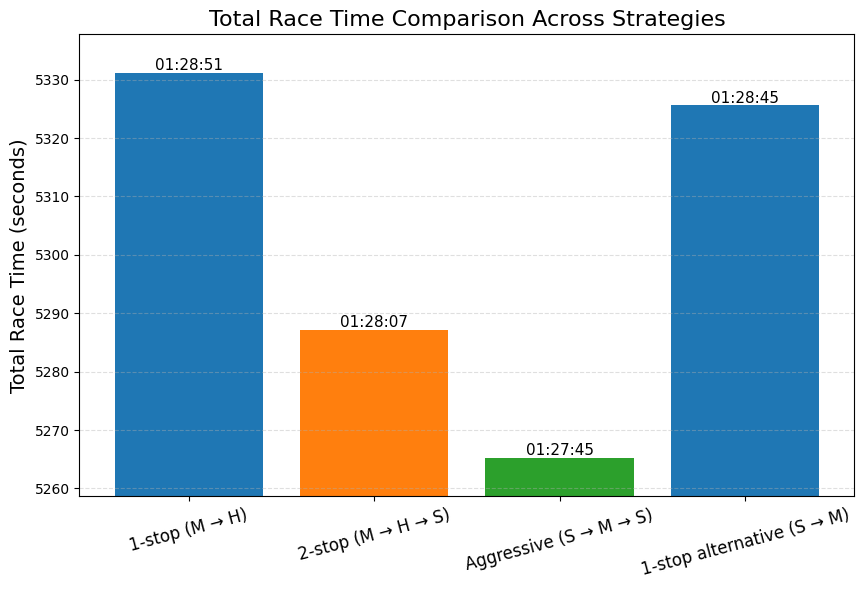

In [2]:
import matplotlib.pyplot as plt

# Convert results dict to a DataFrame (if not already done)
df = pd.DataFrame.from_dict(results, orient="index", columns=["Total Race Time (s)"])

# Helper function to convert seconds → HH:MM:SS
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

# Compute a tighter y-axis range
min_time = df["Total Race Time (s)"].min()
max_time = df["Total Race Time (s)"].max()
padding = (max_time - min_time) * 0.1

plt.figure(figsize=(10, 6))
bars = plt.bar(df.index, df["Total Race Time (s)"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])

# Add HH:MM:SS labels on top of bars
for bar in bars:
    height = bar.get_height()
    label = format_time(height)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        label,
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.title("Total Race Time Comparison Across Strategies", fontsize=16)
plt.ylabel("Total Race Time (seconds)", fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.ylim(min_time - padding, max_time + padding)

plt.show()


In [8]:


# --- Imports ---
import fastf1
from fastf1 import plotting
import pandas as pd
import matplotlib.pyplot as plt
import os # Import the os module

# Enable FastF1 cache (recommended)
cache_dir = 'data/f1_cache'
os.makedirs(cache_dir, exist_ok=True) # Create the directory if it doesn't exist
fastf1.Cache.enable_cache(cache_dir)

# --- Load the 2025 Bahrain Grand Prix Race Session ---
# Session types: 'R' = Race, 'Q' = Qualifying, 'FP1', 'FP2', etc.
session = fastf1.get_session(2025, 'Bahrain', 'R')
session.load()   # This downloads timing data

# --- Get Max Verstappen's laps ---
driver_code = "VER"
laps_ver = session.laps.pick_driver(driver_code)

# Display the first few laps
laps_ver[['LapNumber', 'LapTime']].head()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

,LapNumber,LapTime
285,1.0,0 days 00:01:43.877000
286,2.0,0 days 00:01:38.403000
287,3.0,0 days 00:01:38.475000
288,4.0,0 days 00:01:38.549000
289,5.0,0 days 00:01:38.760000


/tmp/ipython-input-1000840006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_ver['LapTimeSeconds'] = laps_ver['LapTime'].dt.total_seconds()


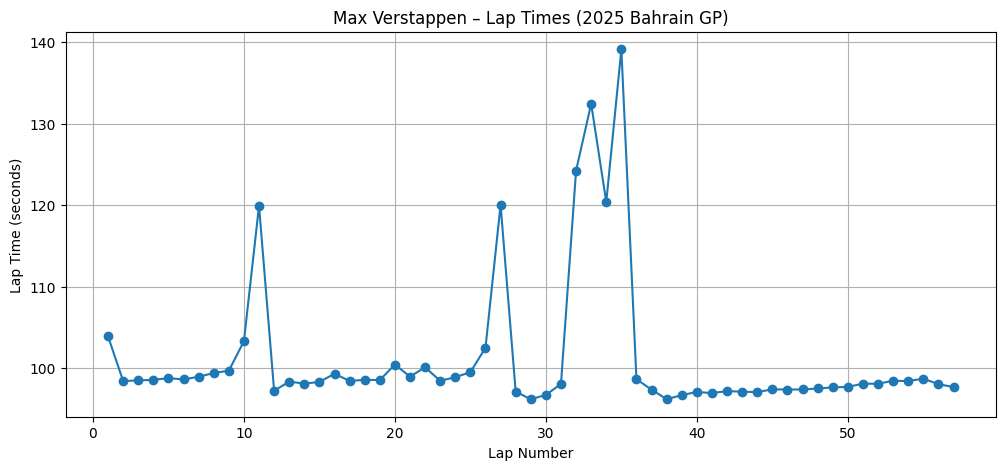

In [3]:
# Convert LapTime to seconds for easier plotting
laps_ver['LapTimeSeconds'] = laps_ver['LapTime'].dt.total_seconds()

plt.figure(figsize=(12,5))
plt.plot(laps_ver['LapNumber'], laps_ver['LapTimeSeconds'], marker='o')
plt.title("Max Verstappen – Lap Times (2025 Bahrain GP)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.grid(True)
plt.show()


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
/Users/jeffreylgoode/Documents/f1-capstone-project/.venv/lib/py

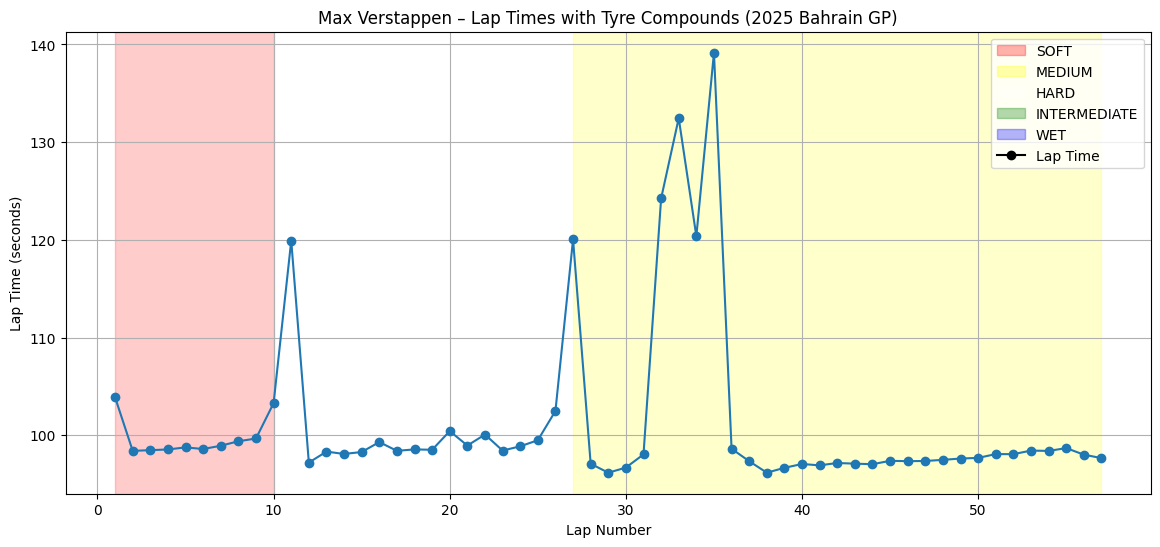

In [9]:


# --- Imports ---
import fastf1
from fastf1 import plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable cache
fastf1.Cache.enable_cache('data/f1_cache')

# --- Load the 2025 Bahrain GP Race ---
session = fastf1.get_session(2025, 'Bahrain', 'R')
session.load()

# --- Get Verstappen's laps ---
laps = session.laps.pick_driver("VER").copy()

# Convert LapTime to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# --- Identify stints ---
# FastF1 provides a 'Stint' column and 'Compound' column
stints = laps[['LapNumber', 'Stint', 'Compound']]

# Group by stint to get start/end lap for each tyre compound
stint_ranges = stints.groupby('Stint').agg(
    start_lap=('LapNumber', 'min'),
    end_lap=('LapNumber', 'max'),
    compound=('Compound', 'first')
).reset_index()

# --- Plotting ---
plt.figure(figsize=(14,6))

# Plot lap times
plt.plot(laps['LapNumber'], laps['LapTimeSeconds'], marker='o', label='Lap Time')

# Color map for tyre compounds
compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'yellow',
    'HARD': 'white',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}

# Add shaded regions for each stint
for _, row in stint_ranges.iterrows():
    color = compound_colors.get(row['compound'], 'gray')
    plt.axvspan(row['start_lap'], row['end_lap'], color=color, alpha=0.2)

# Legend for tyre compounds
patches = [mpatches.Patch(color=c, alpha=0.3, label=comp)
           for comp, c in compound_colors.items()]
plt.legend(handles=patches + [plt.Line2D([], [], marker='o', color='black', label='Lap Time')])

plt.title("Max Verstappen – Lap Times with Tyre Compounds (2025 Bahrain GP)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.grid(True)
plt.show()


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
/Users/jeffreylgoode/Documents/f1-capstone-project/.venv/lib/py

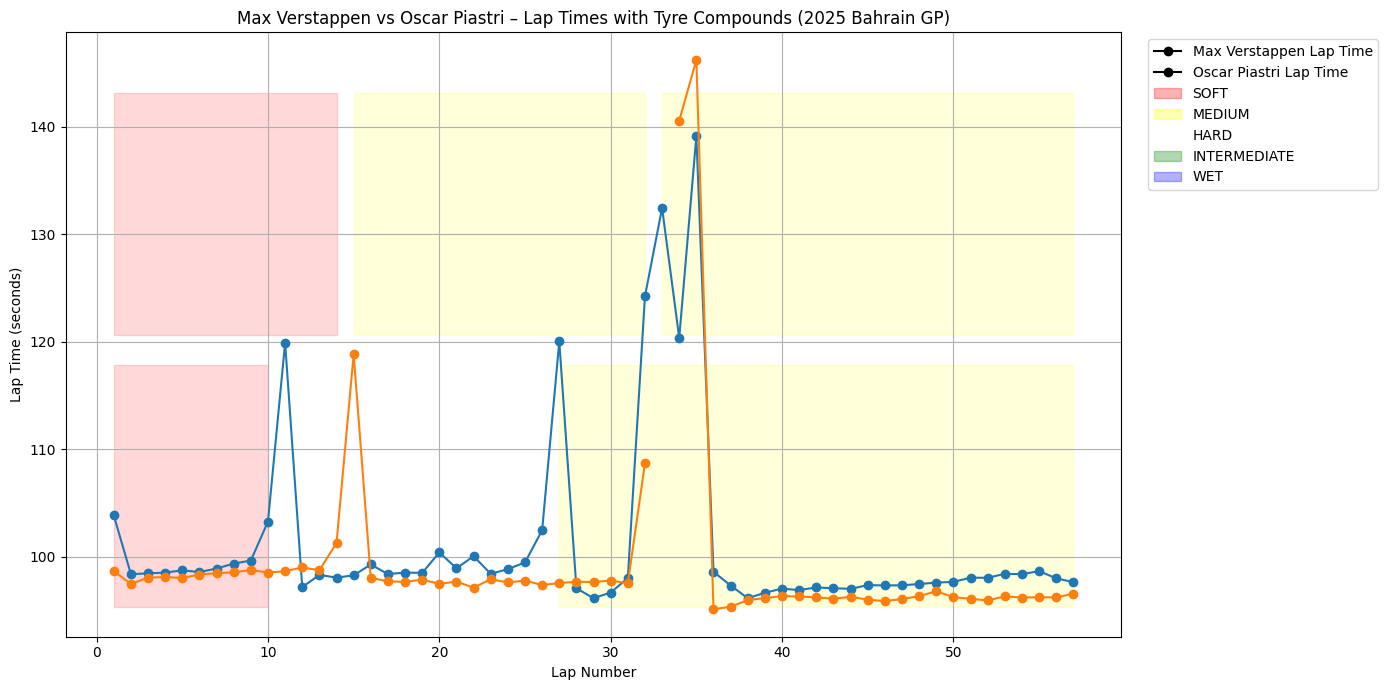

In [10]:


# --- Imports ---
import fastf1
from fastf1 import plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable cache
fastf1.Cache.enable_cache('data/f1_cache')

# --- Load the 2025 Bahrain GP Race ---
session = fastf1.get_session(2025, 'Bahrain', 'R')
session.load()

# --- Drivers to compare ---
drivers = {
    "VER": "Max Verstappen",
    "PIA": "Oscar Piastri"
}

# --- Extract laps for each driver ---
driver_laps = {}
driver_stints = {}

for code, name in drivers.items():
    laps = session.laps.pick_driver(code).copy()
    laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
    driver_laps[code] = laps

    # Build stint ranges
    stints = laps[['LapNumber', 'Stint', 'Compound']]
    stint_ranges = stints.groupby('Stint').agg(
        start_lap=('LapNumber', 'min'),
        end_lap=('LapNumber', 'max'),
        compound=('Compound', 'first')
    ).reset_index()
    driver_stints[code] = stint_ranges

# --- Plotting ---
plt.figure(figsize=(15,7))

# Color map for tyre compounds
compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'yellow',
    'HARD': 'white',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}

# Plot each driver's lap times
for code, name in drivers.items():
    laps = driver_laps[code]
    plt.plot(laps['LapNumber'], laps['LapTimeSeconds'], marker='o', label=name)

# Add shaded stint regions for each driver (stacked vertically)
ymin, ymax = plt.ylim()
height = (ymax - ymin) * 0.45  # each driver gets half the vertical space

for i, (code, name) in enumerate(drivers.items()):
    offset = ymin + i * height
    stints = driver_stints[code]

    for _, row in stints.iterrows():
        color = compound_colors.get(row['compound'], 'gray') # Fixed: Access 'compound' from row
        plt.axvspan(row['start_lap'], row['end_lap'], color=color, alpha=0.15, ymin=0.05 + i*0.45, ymax=0.45 + i*0.45)

# Create a single legend for both lap times and tyre compounds
handles = []
for code, name in drivers.items():
    handles.append(plt.Line2D([], [], marker='o', color='black', label=name + ' Lap Time'))

# Add compound patches to the legend
compound_patches = [mpatches.Patch(color=c, alpha=0.3, label=comp)
                    for comp, c in compound_colors.items()]
handles.extend(compound_patches)

plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.25, 1))

plt.title("Max Verstappen vs Oscar Piastri – Lap Times with Tyre Compounds (2025 Bahrain GP)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for the legend
plt.show()

core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

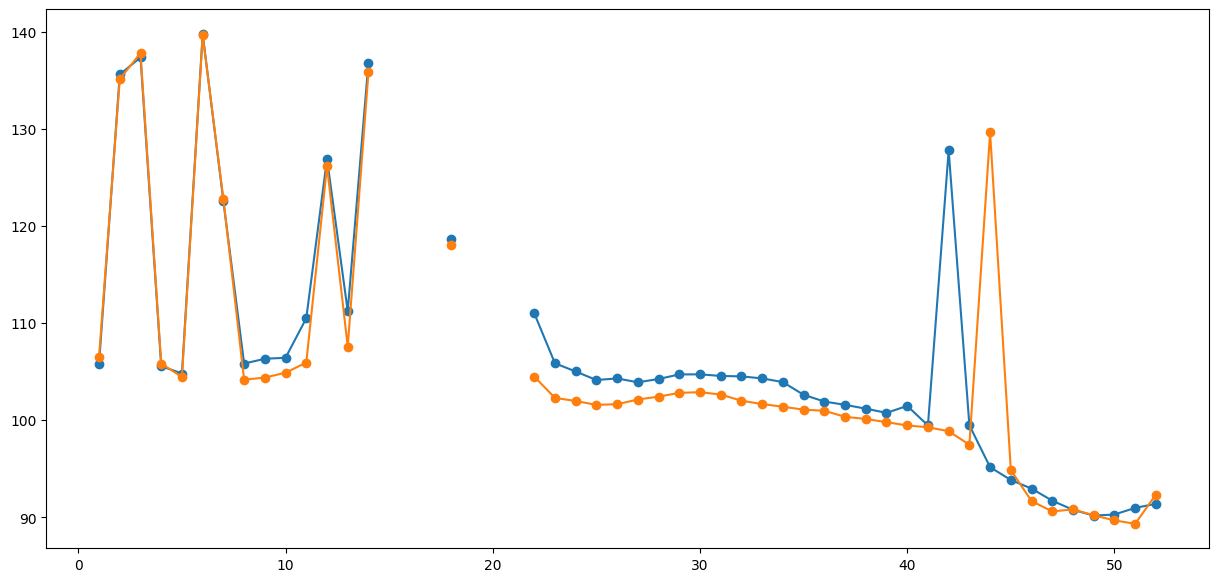

In [12]:


# --- Imports ---
import fastf1
from fastf1 import plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable cache
fastf1.Cache.enable_cache('data/f1_cache')

# --- Load the 2025 British GP Race (Silverstone) ---
session = fastf1.get_session(2025, 'Silverstone', 'R')
session.load()

# --- Drivers to compare ---
drivers = {
    "VER": "Max Verstappen",
    "PIA": "Oscar Piastri"
}

# --- Extract laps + stints for each driver ---
driver_laps = {}
driver_stints = {}

for code, name in drivers.items():
    laps = session.laps.pick_driver(code).copy()
    laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
    driver_laps[code] = laps

    # Build stint ranges
    stints = laps[['LapNumber', 'Stint', 'Compound']]
    stint_ranges = stints.groupby('Stint').agg(
        start_lap=('LapNumber', 'min'),
        end_lap=('LapNumber', 'max'),
        compound=('Compound', 'first')
    ).reset_index()
    driver_stints[code] = stint_ranges

# --- Plotting ---
plt.figure(figsize=(15,7))

# Color map for tyre compounds
compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'yellow',
    'HARD': 'white',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}

# Plot each driver's lap times
for code, name in drivers.items():
    laps = driver_laps[code]
    plt.plot(laps['LapNumber'], laps['LapTimeSeconds'], marker='o', label=name)

# Add shaded stint regions for

events      WARNING 	Correcting user input 'United States' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track

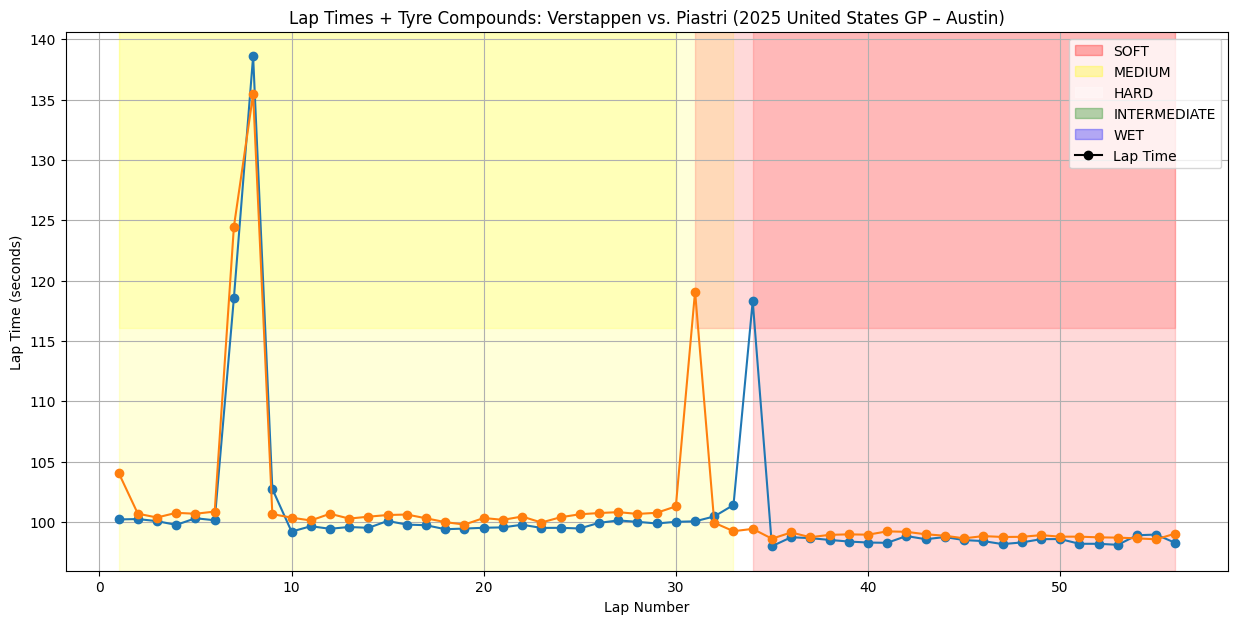

In [13]:


# --- Imports ---
import fastf1
from fastf1 import plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable cache
fastf1.Cache.enable_cache('data/f1_cache')

# --- Load the 2025 United States GP Race (Austin, COTA) ---
session = fastf1.get_session(2025, 'United States', 'R')
session.load()

# --- Drivers to compare ---
drivers = {
    "VER": "Max Verstappen",
    "PIA": "Oscar Piastri"
}

# --- Extract laps + stints for each driver ---
driver_laps = {}
driver_stints = {}

for code, name in drivers.items():
    laps = session.laps.pick_driver(code).copy()
    laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
    driver_laps[code] = laps

    # Build stint ranges
    stints = laps[['LapNumber', 'Stint', 'Compound']]
    stint_ranges = stints.groupby('Stint').agg(
        start_lap=('LapNumber', 'min'),
        end_lap=('LapNumber', 'max'),
        compound=('Compound', 'first')
    ).reset_index()
    driver_stints[code] = stint_ranges

# --- Plotting ---
plt.figure(figsize=(15,7))

# Color map for tyre compounds
compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'yellow',
    'HARD': 'white',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}

# Plot each driver's lap times
for code, name in drivers.items():
    laps = driver_laps[code]
    plt.plot(laps['LapNumber'], laps['LapTimeSeconds'], marker='o', label=name)

# Add shaded stint regions for each driver (stacked vertically)
ymin, ymax = plt.ylim()
height = (ymax - ymin) * 0.45  # each driver gets half the vertical space

for i, (code, name) in enumerate(drivers.items()):
    offset = ymin + i * height
    stints = driver_stints[code]

    for _, row in stints.iterrows():
        color = compound_colors.get(row['compound'], 'gray')
        plt.axvspan(
            row['start_lap'], row['end_lap'],
            ymin=(offset - ymin) / (ymax - ymin),
            ymax=(offset + height) / (ymax - ymin),
            color=color, alpha=0.15
        )

# Build tyre compound legend
patches = [mpatches.Patch(color=c, alpha=0.3, label=comp)
           for comp, c in compound_colors.items()]

plt.legend(handles=patches + [plt.Line2D([], [], marker='o', color='black', label='Lap Time')])

plt.title("Lap Times + Tyre Compounds: Verstappen vs. Piastri (2025 United States GP – Austin)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.grid(True)
plt.show()


events      WARNING 	Correcting user input 'United States' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '44', '81', '63', '22', '27', '87', '14', '30', '18', '12', '23', '

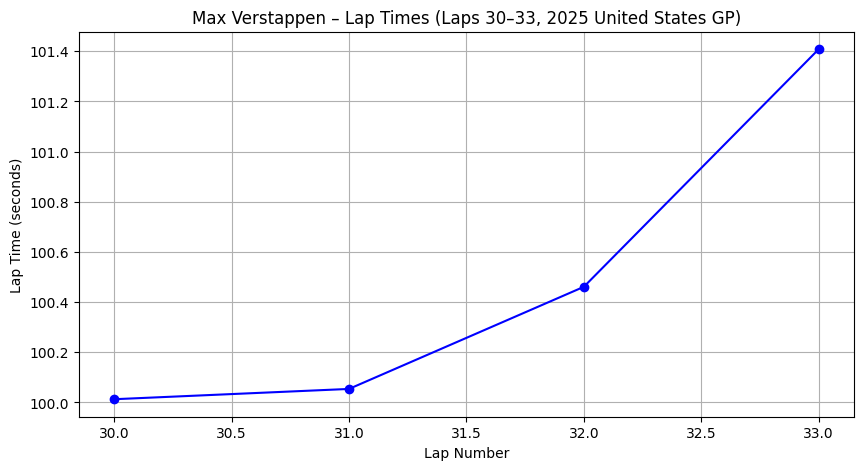

In [16]:


# --- Imports ---
import fastf1
import matplotlib.pyplot as plt

# Enable cache
fastf1.Cache.enable_cache('data/f1_cache')

# --- Load the 2025 United States GP Race (Austin) ---
session = fastf1.get_session(2025, 'United States', 'R')
session.load()

# --- Get Verstappen's laps ---
laps = session.laps.pick_driver("VER").copy()
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# Filter laps 30–33
subset = laps[(laps['LapNumber'] >= 30) & (laps['LapNumber'] <= 33)]

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(subset['LapNumber'], subset['LapTimeSeconds'], marker='o', color='blue')

plt.title("Max Verstappen – Lap Times (Laps 30–33, 2025 United States GP)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.grid(True)
plt.show()
